# Введение в RL и пакет Gymnasium

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://gymnasium.farama.org/
* https://pypi.org/project/ufal.pybox2d/
* https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/
* https://gymnasium.farama.org/api/spaces/fundamental/
* https://gymnasium.farama.org/environments/toy_text/blackjack/

## Задачи для совместного разбора

1\. Рассмотрите пример создания окружения `gymnasium` и основные этапы взаимодействия с этим окружением.

<img src="https://gymnasium.farama.org/_images/AE_loop.png" width="300"/>

In [1]:
import gymnasium as gym

In [2]:
env = gym.make('LunarLander-v3', render_mode='human')

def make_action(obs, env):
  # тут вы должны исопльзовать состояние
  return env.action_space.sample()

obs, _ = env.reset()
is_done = False
rewards = []
while not is_done:
  action = make_action(obs, env)
  obs, reward, terminated, truncated, info = env.step(action)

  is_done = terminated or truncated
  rewards.append(reward)

env.close()

In [3]:
sum(rewards)

np.float64(-110.15982510276616)

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Создайте окружение `Blackjack-v1`. Сыграйте `N=10000` игр, выбирая действие случайным образом. Посчитайте и выведите на экран долю выигранных игр.

- [ ] Проверено на семинаре

In [4]:
env = gym.make('Blackjack-v1')
N = 10000
wins = 0

for _ in range(N):
    obs, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
    if reward == 1:
        wins += 1

In [5]:
win_ratio = wins / N
print(f'Доля выигранных игр: {win_ratio}')

Доля выигранных игр: 0.2813


<p class="task" id="2"></p>

2\. Создайте окружение `Blackjack-v1`. Предложите стратегию, которая позволит, в среднем, выигрывать чаще, чем случайный выбор действия. Реализуйте эту стратегию и сыграйте `N=10000` игр, выбирая действие согласно этой стратегии. Посчитайте и выведите на экран долю выигранных игр.

- [ ] Проверено на семинаре

In [6]:
env = gym.make('Blackjack-v1')
N = 10000
wins = 0

def strategy(obs):
    player_sum, dealer_card, usable_ace = obs
    if player_sum < 16:
        return 1
    else:
        return 0

for _ in range(N):
    obs, _ = env.reset()
    done = False
    while not done:
        action = strategy(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
    if reward == 1:
        wins += 1

In [7]:
win_ratio = wins / N
print(f'Доля выигранных игр: {win_ratio}')

Доля выигранных игр: 0.4238


<p class="task" id="3"></p>

3\. Создайте окружение для игры в крестики-нолики, реализовав интерфейс `gym.Env`. Решение должно удовлетворять следующим условиям:
* для создания пространства состояний используется `spaces.Box`;
* для создания пространства действий используется `spaces.MultiDiscrete`;
* игра прекращается, если:
    - нет возможности сделать ход;
    - игрок пытается отметить уже выбранную ячейку.
* после каждого хода игрок получает награду:
    - 0, если игра не закончена;
    - 1, если игрок выиграл;
    - -1, если игрок проиграл.
* стратегию выбора действия для второго игрока (машины) определите самостоятельно.

Стратегия поведения машины является частью окружения и должна быть реализована внутри него. Сделайте все соответствующие переменные и методы приватными (названия всех переменных начинаются с `__`), подчеркнув, что у пользователя не должно быть к ним доступа извне.

Сыграйте одну игру, выбирая действия случайным образом. Выведите на экран состояние окружения после каждого хода и итоговую награду пользователя за сессию.

- [ ] Проверено на семинаре

In [8]:
from gymnasium import spaces
import numpy as np
import random

In [9]:
class TicTacToeEnv(gym.Env):
    def __init__(self, draw=True):
        super(TicTacToeEnv, self).__init__()
        self.observation_space = spaces.Box(low=0, high=2, shape=(3, 3), dtype=np.int8)
        self.action_space = spaces.MultiDiscrete([3, 3])
        self.board = np.zeros((3, 3), dtype=np.int8)
        self.done = False
        self.draw = draw
        self.reward = 0
        self.info = {}
    
    def reset(self):
        self.board = np.zeros((3, 3), dtype=np.int8)
        self.done = False
        self.reward = 0
        self.info = {}
        return self.board.copy(), self.info
    
    def step(self, action):
        if self.done:
            raise ValueError('Игра уже завершена')
        
        user_row, user_col = action
        if self.board[user_row, user_col] != 0:
            self.done = True
            self.reward = -1
            return self.board.copy(), self.reward, self.done, False, self.info
        
        self.board[user_row, user_col] = 1
        if self.check_winner(1):
            self.done = True
            self.reward = 1
            return self.board.copy(), self.reward, self.done, False, self.info
        
        if self.is_board_full():
            self.done = True
            self.reward = -1
            return self.board.copy(), self.reward, self.done, False, self.info
        
        machine_move = self.get_machine_move()
        if machine_move is not None:
            machine_row, machine_col = machine_move
            self.board[machine_row, machine_col] = 2
            if self.check_winner(2):
                self.done = True
                self.reward = -1
                return self.board.copy(), self.reward, self.done, False, self.info
        
        if self.is_board_full():
            self.done = True
            self.reward = -1
            return self.board.copy(), self.reward, self.done, False, self.info
        
        self.reward = 0
        return self.board.copy(), self.reward, self.done, False, self.info
    
    def render(self, mode='human'):
        symbol_map = {0: ' ', 1: 'X', 2: 'O'}
        if self.draw:
            print('-'*13)
        for row in self.board:
            row_symbols = [symbol_map[cell] for cell in row]
            if self.draw:
                print(f'| {' | '.join(row_symbols)} |')
                print('-'*13)
    
    def check_winner(self, player):
        for i in range(3):
            if np.all(self.board[i, :] == player):
                return True
            if np.all(self.board[:, i] == player):
                return True
        if self.board[0, 0] == player and self.board[1, 1] == player and self.board[2, 2] == player:
            return True
        if self.board[0, 2] == player and self.board[1, 1] == player and self.board[2, 0] == player:
            return True
        return False
    
    def is_board_full(self):
        return not np.any(self.board == 0)
    
    def get_machine_move(self):
        available_actions = self.get_available_actions()
        if not available_actions:
            return None
        return random.choice(available_actions)
    
    def get_user_move_strategy(self):
        return self.action_space.sample()
    
    def get_available_actions(self):
        return list(zip(*np.where(self.board == 0)))

In [10]:
env = TicTacToeEnv()
observation, info = env.reset()
done = False
total_reward = 0
episode = 0

In [11]:
print('Начальное состояние:')
env.render(mode='human')

Начальное состояние:
-------------
|   |   |   |
-------------
|   |   |   |
-------------
|   |   |   |
-------------


In [12]:
while not done:
    action = env.get_user_move_strategy()
    print(f'Ход пользователя: {action}')
    
    observation, reward, done, truncated, info = env.step(action)
    env.render()
    
    total_reward += reward
    episode += 1
    
    if done:
        if reward == 1:
            print('Пользователь выиграл!')
        elif reward == -1:
            print('Пользователь проиграл!')
        else:
            print('Ничья!')

print(f'Итоговая награда пользователя: {total_reward}')

Ход пользователя: [2 0]
-------------
|   |   |   |
-------------
|   | O |   |
-------------
| X |   |   |
-------------
Ход пользователя: [0 1]
-------------
|   | X | O |
-------------
|   | O |   |
-------------
| X |   |   |
-------------
Ход пользователя: [1 0]
-------------
|   | X | O |
-------------
| X | O |   |
-------------
| X | O |   |
-------------
Ход пользователя: [0 0]
-------------
| X | X | O |
-------------
| X | O |   |
-------------
| X | O |   |
-------------
Пользователь выиграл!
Итоговая награда пользователя: 1


<p class="task" id="4"></p>

4\. Предложите стратегию (в виде алгоритма без использования методов машинного обучения), которая позволит, в среднем, выигрывать в крестики-нолики чаще, чем случайный выбор действия. Реализуйте эту стратегию и сыграйте игру, выбирая действия согласно этой стратегии. Выведите на экран состояние окружения после каждого хода и итоговую награду пользователя за сессию.

- [ ] Проверено на семинаре

In [13]:
from tqdm import tqdm

In [14]:
def get_user_move_strategy(self):
    for move in self.get_available_actions():
        row, col = move
        self.board[row, col] = 1
        if self.check_winner(1):
            self.board[row, col] = 0
            return (row, col)
        self.board[row, col] = 0

    for move in self.get_available_actions():
        row, col = move
        self.board[row, col] = 2
        if self.check_winner(2):
            self.board[row, col] = 0
            return (row, col)
        self.board[row, col] = 0

    if self.board[1, 1] == 0:
        return (1, 1)

    corners = [(0,0), (0,2), (2,0), (2,2)]
    available_corners = [corner for corner in corners if self.board[corner] == 0]
    if available_corners:
        return random.choice(available_corners)

    sides = [(0,1), (1,0), (1,2), (2,1)]
    available_sides = [side for side in sides if self.board[side] == 0]
    if available_sides:
        return random.choice(available_sides)

    return None

In [15]:
env = TicTacToeEnv()
env.get_user_move_strategy = get_user_move_strategy.__get__(env, TicTacToeEnv)
observation, info = env.reset()
done = False
total_reward = 0
episode = 0

In [16]:
while not done:
    action = env.get_user_move_strategy()
    print(f'Ход пользователя: {action}')
    
    observation, reward, done, truncated, info = env.step(action)
    env.render()
    
    total_reward += reward
    episode += 1
    
    if done:
        if reward == 1:
            print('Пользователь выиграл!')
        elif reward == -1:
            print('Пользователь проиграл!')
        else:
            print('Ничья!')

print(f'Итоговая награда пользователя: {total_reward}')

Ход пользователя: (1, 1)
-------------
|   |   |   |
-------------
|   | X |   |
-------------
| O |   |   |
-------------
Ход пользователя: (2, 2)
-------------
|   |   |   |
-------------
|   | X |   |
-------------
| O | O | X |
-------------
Ход пользователя: (np.int64(0), np.int64(0))
-------------
| X |   |   |
-------------
|   | X |   |
-------------
| O | O | X |
-------------
Пользователь выиграл!
Итоговая награда пользователя: 1


In [17]:
N = 10000
data = {-1: 0, 1: 0}
env = TicTacToeEnv(draw=False)
env.get_user_move_strategy = get_user_move_strategy.__get__(env, TicTacToeEnv)
for i in tqdm(range(N)):
    env.reset()

    observation, info = env.reset()
    done = False
    total_reward = 0
    episode = 0
    
    while not done:
        action = env.get_user_move_strategy()
        
        observation, reward, done, truncated, info = env.step(action)
        env.render()
        
        total_reward += reward
        episode += 1
        
        if done:
            data[reward] += 1

100%|██████████| 10000/10000 [00:08<00:00, 1140.88it/s]


In [18]:
rename_map = {-1: 'проигрыш', 1: 'выигрыш'}
for k, v in data.items():
    print(f'Игры, закончившиеся с результатом {rename_map[k]}: {v} ({v/N}%)')

Игры, закончившиеся с результатом проигрыш: 398 (0.0398%)
Игры, закончившиеся с результатом выигрыш: 9602 (0.9602%)


<p class="task" id="5"></p>

5\. Создайте окружение `MountainCar-v0`. Проиграйте 10 эпизодов и сохраните на диск файл с записью каждого пятого эпизода. Для записи видео воспользуйтесь обёрткой `RecordVideo`. Вставьте скриншот, на котором видно, что файлы были созданы.

- [ ] Проверено на семинаре

In [19]:
from gymnasium.wrappers import RecordVideo

In [23]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env = RecordVideo(env, video_folder='./trash', episode_trigger=lambda x: (x+1) % 5 == 0)

In [21]:
for episode in range(10):
    obs, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        done = done or truncated
env.close()

![Снимок экрана 2024-12-12 в 10.54.23.png](<attachment:Снимок экрана 2024-12-12 в 10.54.23.png>)
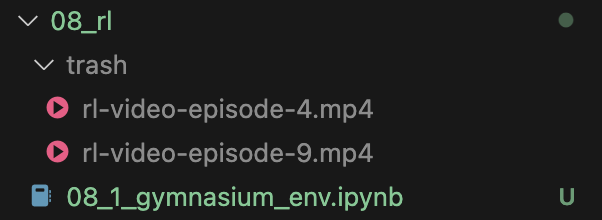